In [1]:
# Alexandre Brilhante

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

db = 'database.sqlite'
connect = sqlite3.connect(db)
query = "SELECT name FROM sqlite_master WHERE type = 'table';"

In [2]:
# Initialization
query = "SELECT * FROM player"
players_df = pd.read_sql(query, connect)
query = "SELECT * FROM player_attributes"
player_stats_df = pd.read_sql(query, connect)

In [3]:
# Merge the player and player_attribute data
df = players_df.merge(player_stats_df, how='inner', on='player_api_id')

# Date adjusting
df['date'] = pd.to_datetime(df['date'])

# Unnecessary columns
df.drop(['id_x', 'id_y', 'player_fifa_api_id_x', 'player_fifa_api_id_y'], 1, inplace=True)
ratings_df = df[['player_api_id', 'player_name', 'date', 'overall_rating', 'potential']]

# Drop players without any rating
ratings_df = ratings_df.drop(ratings_df[ratings_df['overall_rating'].isnull()].index)

# Sorting by rating
ratings_df.sort_values(['player_name', 'overall_rating'],
                       ascending=[True, False], inplace=True)

# Change the date to just the year
ratings_df['date'] = ratings_df['date'].apply(lambda x: x.year)

In [4]:
# Grouping the players by the year
group = ratings_df.groupby('date')

In [5]:
# Ranking players based on overall ratings, removing duplicates first
data = group.apply(lambda x: x.drop_duplicates(subset = 'player_api_id', keep = 'first').
                   sort_values(by=['overall_rating'], ascending=[False]).reset_index(drop=True).head(15))

In [6]:
# Best team possible for each year
data

player_api_id             player_name  date  overall_rating  \
date                                                                   
2007 0           30829            Wayne Rooney  2007            93.0   
     1           30717        Gianluigi Buffon  2007            93.0   
     2           39989          Gregory Coupet  2007            92.0   
     3           30893       Cristiano Ronaldo  2007            91.0   
     4           30743              Ronaldinho  2007            91.0   
     5           30626           Thierry Henry  2007            91.0   
     6           30627              John Terry  2007            91.0   
     7           30723        Alessandro Nesta  2007            91.0   
     8           34520         Fabio Cannavaro  2007            91.0   
     9           30714         Francesco Totti  2007            90.0   
     10          30728         David Trezeguet  2007            90.0   
     11          30631           Frank Lampard  2007            90.0   
     12          38843              Ze Roberto  2007            90.0   
     13          41044                    Kaka  2007            90.0   
     14          30661            Carles Puyol  2007            89.0   
2008 0           30657           Iker Casillas  2008            91.0   
     1           30893       Cristiano Ronaldo  2008            91.0   
     2           30717        Gianluigi Buffon  2008            90.0   
     3           30981            Lionel Messi  2008            90.0   
     4           41044                    Kaka  2008            90.0   
     5           35724      Zlatan Ibrahimovic  2008            89.0   
     6           30627              John Terry  2008            88.0   
     7           30723        Alessandro Nesta  2008            88.0   
     8           30618          Steven Gerrard  2008            88.0   
     9           30661            Carles Puyol  2008            88.0   
     10          30853         Fernando Torres  2008            88.0   
     11          30859               Petr Cech  2008            88.0   
     12          30924           Franck Ribery  2008            88.0   
     13          30613           Cesc Fabregas  2008            88.0   
     14          30894            Philipp Lahm  2008            87.0   
...                ...                     ...   ...             ...   
2015 0           30981            Lionel Messi  2015            94.0   
     1           30893       Cristiano Ronaldo  2015            93.0   
     2           30834            Arjen Robben  2015            90.0   
     3           40636             Luis Suarez  2015            90.0   
     4           27299            Manuel Neuer  2015            90.0   
     5           35724      Zlatan Ibrahimovic  2015            89.0   
     6          107417             Eden Hazard  2015            89.0   
     7           19533                  Neymar  2015            89.0   
     8           37459             David Silva  2015            88.0   
     9           80562            Thiago Silva  2015            88.0   
     10          30872  Bastian Schweinsteiger  2015            88.0   
     11          30955          Andres Iniesta  2015            88.0   
     12          30924           Franck Ribery  2015            88.0   
     13          95078              Toni Kroos  2015            87.0   
     14          36378             Mesut Oezil  2015            87.0   
2016 0           19533                  Neymar  2016            90.0   
     1           27299            Manuel Neuer  2016            90.0   
     2           30834            Arjen Robben  2016            89.0   
     3           36378             Mesut Oezil  2016            88.0   
     4          107417             Eden Hazard  2016            88.0   
     5           37412           Sergio Aguero  2016            88.0   
     6           93447      Robert Lewandowski  2016            88.0   
     7           30613           Cesc Fabregas  2

In [7]:
# Bonus: the best team is 2007
data.groupby('date').sum().sort_values(['overall_rating'], ascending=[False])

,player_api_id,overall_rating,potential
date,,,
2007,492288,1363.0,1378.0
2012,481456,1344.0,1365.0
2011,491434,1343.0,1365.0
2014,607749,1342.0,1351.0
2013,531335,1340.0,1354.0
2015,665545,1338.0,1349.0
2008,476788,1332.0,1375.0
2009,477325,1330.0,1376.0
2010,474591,1326.0,1369.0


In [18]:
# Bonus: player evolution
players = players.sort_values('overall_rating', ascending=False)
best_players = players[['player_api_id','player_name']].head(150)
ids = tuple(best_players.player_api_id.unique())

query = "SELECT player_api_id, date, overall_rating, potential FROM player_attributes WHERE player_api_id in %s" % (ids,)

evolution = pd.read_sql(query, connect)
evolution = pd.merge(evolution, best_players)
evolution['year'] = evolution.date.str[:4].apply(int)
evolution = evolution.groupby(['year','player_api_id','player_name']).overall_rating.mean()
evolution = evolution.reset_index()

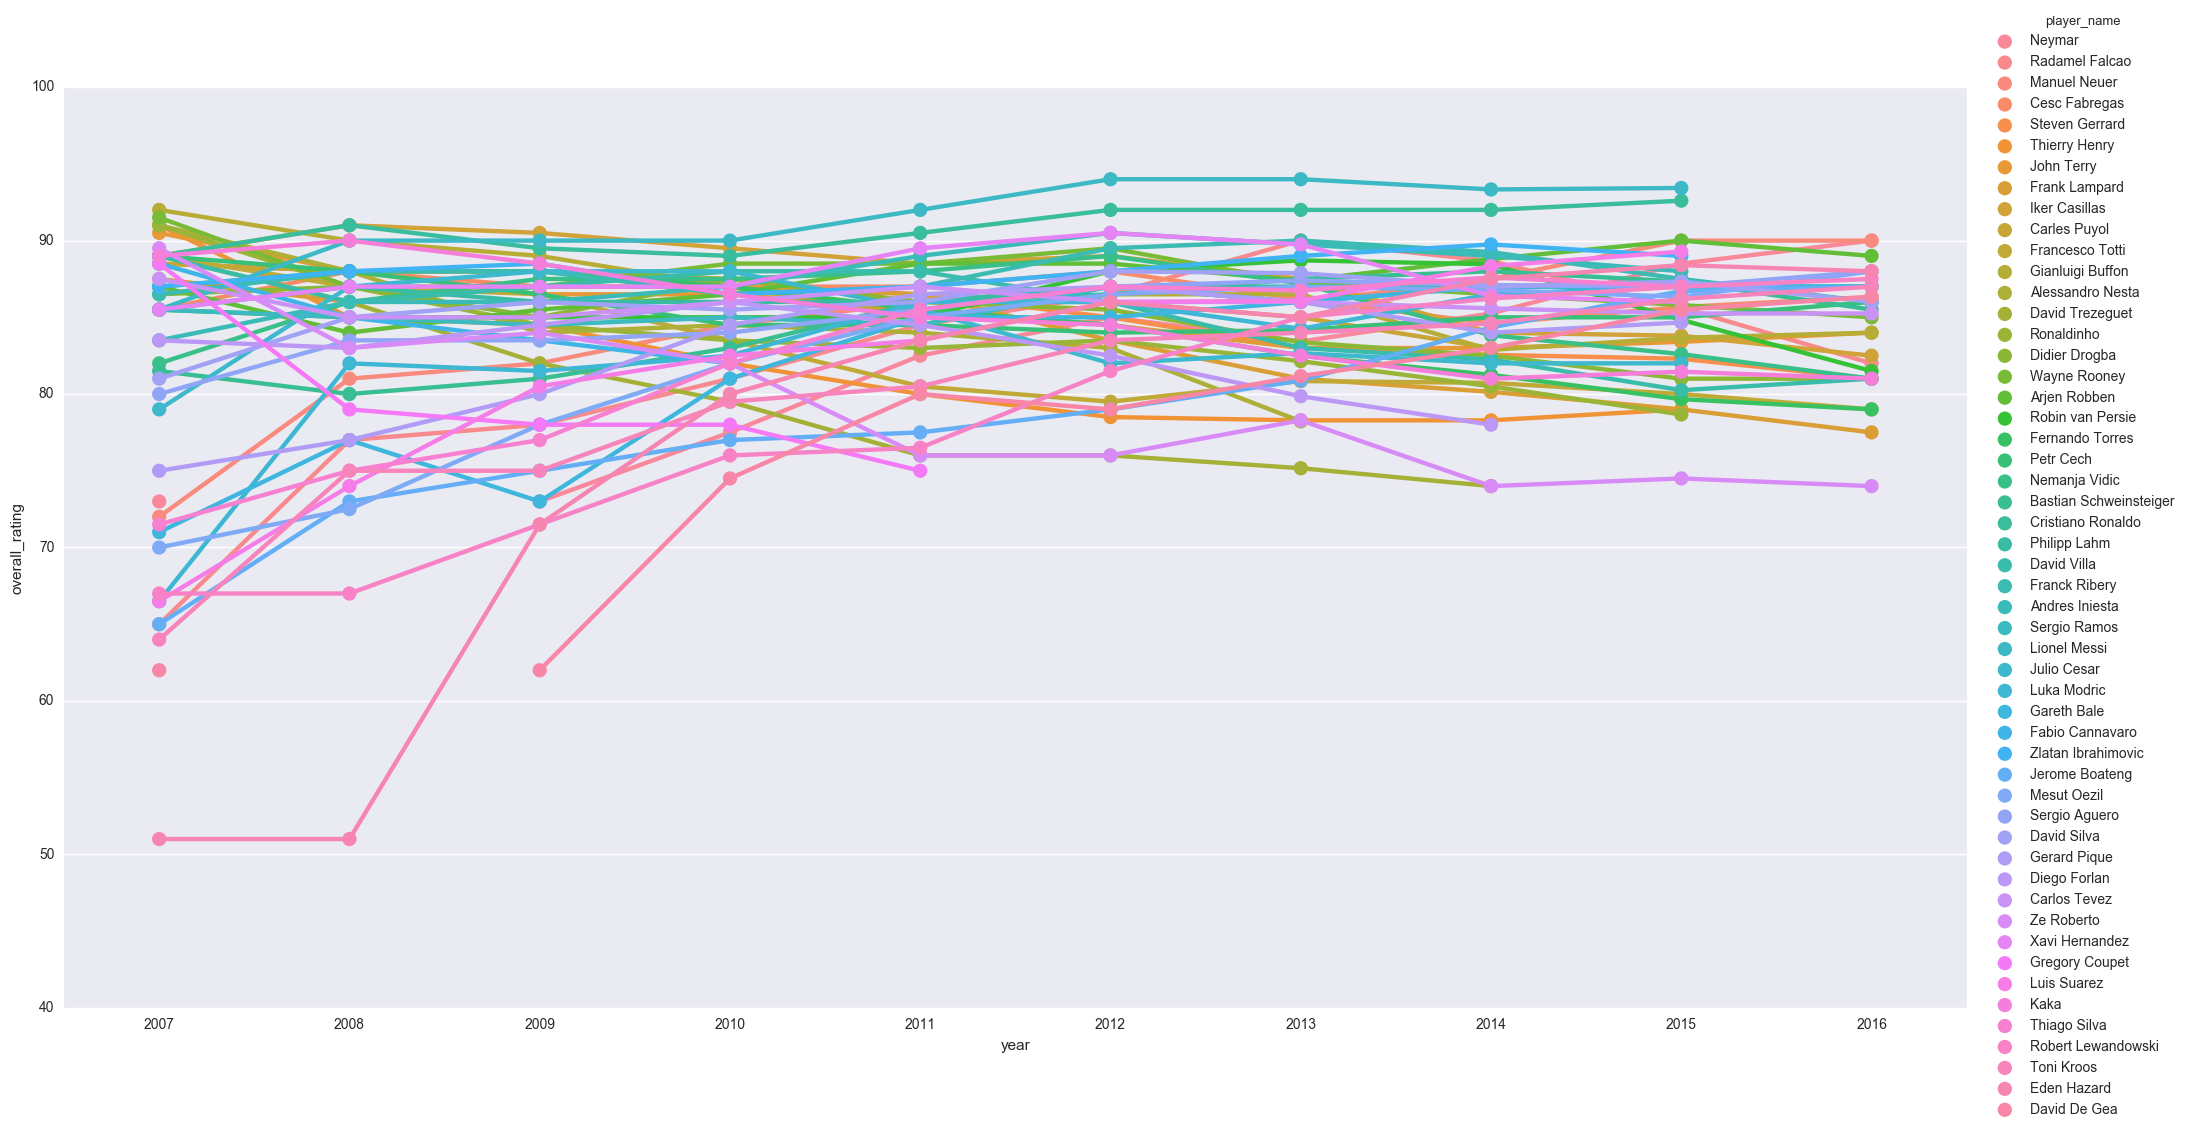

In [27]:
# Not a very clear graph but could be exported to Tableau for a better presentation for example

sns.factorplot(data=evolution[evolution.player_api_id.isin(ids[0:-1])], x='year', y='overall_rating', hue='player_name', size=10, aspect=2)